# Introduction
This notebook intends to present Automatic Differentiation in an accessible and hands-on manner.
- Previous sessions presented the theory, with the practical implementation not fully outlined
- Based on the Black76 example, both the Forward Mode and Reverse Mode are implemented **from scratch**
- **Technical requirements**: Python 3 with the packages below as well as Jupyter are required for a manual run; to view the notebook precompiled regularly **Google Colab** or **Jupyter Notebook/Lab** is sufficient.


In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

## Black76-Formula

To illustrate the abilities of Automatic Differentiation using a practical example, we introduce the Black76-Formula for further analysis. The formula can be used to obtain prices of interest rate derivatives.

$$Black76\left(F,K,\sigma,\tau,\omega\right)=\omega\left[F\Phi\left(\omega d_1\right)-K\Phi\left(\omega d_2\right)\right]$$
$$d_{1,2}=\frac{log(\frac{F}{K})}{\sigma\sqrt\tau}\pm\frac{\sigma\sqrt\tau}{2}$$
Here, ω=-1 denotes European puts and ω= 1 European calls, with $\Phi$ denoting the normal pdf.

The formula consists of basic operations like addition, multiplication and division. Furthermore, the following functions are treated as elementary. This means that calculations within those functions are not broken down further to perform Automatic Differentiation.



In [2]:
def sqrt(x):
        return np.sqrt(x)
def cdf(x):
        return norm.cdf(x)
def log(x):
        return np.log(x)

The formula can now be introduced as python code.

In [3]:
def Black76(forward_price,strike,volatility,maturity,option_type): 
    d_1 = log(forward_price/strike)/(volatility*sqrt(maturity))+(volatility*sqrt(maturity))/2
    d_2 = log(forward_price/strike)/(volatility*sqrt(maturity))-(volatility*sqrt(maturity))/2
    value = option_type * (forward_price*cdf(option_type*d_1)-strike*cdf(option_type*d_2))
    return value

For an option, one would expect an option value of underlying price minus the strike right at the expiry.

In [4]:
Black76(forward_price=150,
        strike=100,
        volatility=1,
        maturity=np.finfo(float).eps,
        option_type=1)

50.0

With an underlying price of 150 and a strike of 100, at expiration the option value is determined to be 50. Lets validate the behaviour out-of-the money with some time left to maturity.

In [5]:
Black76(forward_price=50,
        strike=100,
        volatility=1,
        maturity=1,
        option_type=1)

9.530505761837919

This shows that the option has value out-of-money. For the purposes of risk management and hedging, one may be interested in sensitivities of the formula.

Namely, the effect of a marginal change of the option value with respect to the underlying price or the volatility is an interesting quantity.

# Differentiation
## Numeric differentiation

A first method to obtain derivatives and sensitivities is numerical differentiation, where the function of interest is perturbed with a small shock to see the change in the function value.

This can be represented with the following function:

In [6]:
def numerical_differentiation(function,x):
    h = 1e-7
    return (function(x+h)-function(x))/h

For $f(x)=x^2$ the manual derivative at $x=2$ is expected to be 4.

In [7]:
numerical_differentiation(lambda x: x**2,2)

4.000000091153311

It can be seen that the method obtains an approximate derivative, however with an approximation error. Now let us use numerical differentiation to obtain sensitivities for the Black76-Formula:

In [8]:
numerical_delta = numerical_differentiation(lambda x: Black76(forward_price=x,
        strike=100,
        volatility=1,
        maturity=1,
        option_type=1),50)
print(f"The delta determined by numerical differentiation is {numerical_delta}")

The vega determined by numerical differentiation is 0.4234219019849661


This value is also called the option delta at an underlying value of 50. We can also compute the vega and theta.

In [9]:
numerical_vega = numerical_differentiation(lambda x: Black76(forward_price=50,
        strike=100,
        volatility=x,
        maturity=1,
        option_type=1),1)
print(f"The vega determined by numerical differentiation is {numerical_vega}")

The vega determined by numerical differentiation is 19.57849107725451


In [10]:
numerical_theta = numerical_differentiation(lambda x: Black76(forward_price=50,
        strike=100,
        volatility=1,
        maturity=x,
        option_type=1),1)
print(f"The theta determined by numerical differentiation is {numerical_theta}")

The vega determined by numerical differentiation is 9.789245236646593


To quickly validate this with the explicit greeks, we use the established formulas:
$$Delta=\mathrm{\Phi}\left(d_1\right)$$
$$Vega=F\mathrm{\Phi}'\left(d_1\right)\sqrt\tau$$
$$Theta=-\frac{F\mathrm{\Phi}'\left(d_1\right)\sigma}{2\sqrt\tau}$$


In [11]:
def Black76_delta(forward_price,strike,volatility,maturity,option_type): 
    d_1 = log(forward_price/strike)/(volatility*sqrt(maturity))+(volatility*sqrt(maturity))/2
    return cdf(option_type*d_1)
def Black76_vega(forward_price,strike,volatility,maturity,option_type): 
    d_1 = log(forward_price/strike)/(volatility*sqrt(maturity))+(volatility*sqrt(maturity))/2
    value = forward_price*norm.pdf(option_type*d_1)*sqrt(maturity)
    return value
def Black76_theta(forward_price,strike,volatility,maturity,option_type): 
    d_1 = log(forward_price/strike)/(volatility*sqrt(maturity))+(volatility*sqrt(maturity))/2
    term_1 = ((forward_price*norm.pdf(option_type*d_1)*volatility) / (2*sqrt(maturity)))

    return term_1

In [12]:
delta_analytical = Black76_delta(forward_price=50,
        strike=100,
        volatility=1,
        maturity=1,
        option_type=1)
print(f"The analytical delta is {delta_analytical}")

The analytical delta is 0.4234218517607552


In [13]:
vega_analytical = Black76_vega(forward_price=50,
        strike=100,
        volatility=1,
        maturity=1,
        option_type=1)
print(f"The analytical vega is {vega_analytical}")

The analytical vega is 19.578490801260433


In [14]:
theta_analytical = Black76_theta(forward_price=50,
        strike=100,
        volatility=1,
        maturity=1,
        option_type=1)
print(f"The analytical theta is {theta_analytical}")

The analytical theta is 9.789245400630216


For many different underlying values, a delta curve can be computed:

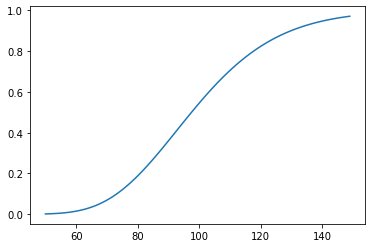

In [15]:
delta_curve = [numerical_differentiation(lambda x: Black76(forward_price=x,
        strike=100,
        volatility=1,
        maturity=0.05,
        option_type=1),i) for i in range(50,150)]
plt.plot(range(50,150),delta_curve)

As expected, the delta curve is steepest near the strike and goes from 0 to 1 in an S-shape. We will check whether Automatic Differentiation can obtain the same curve by computing the derivatives using both the Forward Mode as well as the Reverse Mode.

## Forward Mode Automatic Differentiation
### Definition of dual number class

Following the learnings from the concept of Operator Overloading, we can define a new type of number that can perform all  elementary operations of interest. The main goal is to use the already defined Black76-Formula without making **any** changes. Only the input parameters of the formula will be defined as dual numbers instead of "usual" numbers.

It can be noted that although conceptually a evaluation trace was constructed manually, this will not be necessary for the code implementation. The evaluation trace is implicit in the formula and will be evaluated at runtime of the program.

A dual number can be introduced as followed:

In [16]:
class dual_number:
    def __init__(self,value,derivative):
        self.value = value
        self.derivative = derivative
        
    def __add__(self,other):
        if type(other) == type(self):
            c = dual_number(None,None)
            c.value = self.value + other.value
            c.derivative = self.derivative + other.derivative
            return c      
    def __sub__(self,other):
        if type(other) == type(self):
            c = dual_number(None,None)
            c.value = self.value - other.value
            c.derivative = self.derivative - other.derivative
            return c 
    def __mul__(self,other):
        if type(other) == type(self):
            c = dual_number(None,None)
            c.value = self.value * other.value
            c.derivative = self.derivative * other.value +  self.value*other.derivative
            return c
    def __truediv__ (self,other):
        if type(other) == type(self):
            c = dual_number(None,None)
            c.value = self.value / other.value
            c.derivative = (self.derivative * other.value -  self.value*other.derivative) / other.value ** 2
            return c
        else:
            c = dual_number(None,None)
            c.value = self.value / other
            c.derivative = self.derivative / other
            return c

Instead of just being a single number, the dual number holds two values, an evaluation value and a derivative. Arithmetic operations need to be redefined to make use of this dual structure. First, addition can be defined. Remember the chain rule for adding derivatives: For a function $h(x)=f(x)+g(x)$, the derivative $h'(x)$ equals $$h'(x)=f'(x)+g'(x)$$
Analogously, the addition operator can be defined and added to the dual number class. Similarly, the product rule allows to take the derivative of $h(x)=f(x)g(x)$ in the form $$h'(x)=f'(x)g(x)+f(x)g'(x)$$


The underlying rules are the chain rule and product rule, where the following forward pass is performed:
$$\frac{\partial f}{\partial x}=\frac{\partial f}{\partial v_n}\frac{\partial v_n}{\partial x}$$
$$
=\frac{\partial f}{\partial v_n}\frac{\partial v_n}{\partial v_{n-1}}\frac{\partial v_{n-1}}{\partial x}$$

The number is equipped with $a$ value and a carried derivative for the forward mode. Lets see dual numbers in action using the following function: 
$$c(a,b)=a^2+ab$$

Our expected derivative with respect to $b$ is the value of $a$. For $$a=2$$ and $$b=1$$

In [17]:
a = dual_number(value=2,derivative=0)
b = dual_number(value=1,derivative=1)
c = a*a+a*b
print(c.value)
print(c.derivative)
print(type(c))

6
2
<class '__main__.dual_number'>


It can be seen that the derivative is calculated correctly. Note how the type of the result variable $c$ is not a number, float or integer. It is however a member of the new dual number class, although it can perform arithmetic operations similarly to normal numbers. A few more examples using $$c(x)=x^2$$ and $$c(x)=x^3$$.

In [18]:
c = dual_number(value=2,derivative=1)*dual_number(value=2,derivative=1)
print(c.derivative)

4


In [19]:
c = dual_number(value=1,derivative=1)*dual_number(value=1,derivative=1)*dual_number(value=1,derivative=1)
print(c.derivative)

3


Again, all derivatives are as expected. Next, to evaluate Black76 with Forward Mode Automatic Differentiation, the elementary functions must also be equipped with a separate mode to carry a derivative along with the usual computation.

### Equipping elementary functions with chain rule

In [20]:
def sqrt(x):
    if type(x)==dual_number:
        temp = dual_number(None,None)
        temp.value = np.sqrt(x.value)
        temp.derivative = 0.5*(x.value**(0.5-1))*x.derivative
        return temp
    else:
        return np.sqrt(x)
    
def cdf(x):
    if type(x)==dual_number:
        temp = dual_number(None,None)
        temp.value =  norm.cdf(x.value)
        temp.derivative = norm.pdf(x.value)*x.derivative
        return temp
    else: 
        return norm.cdf(x)    

def log(x):
    if type(x)==dual_number:
        temp = dual_number(None,None)
        temp.value =  np.log(x.value)      
        temp.derivative = (1/x.value)*x.derivative
        return temp
    else: 
        return np.log(x)      

Note that the Black76 did not have to be manipulated at all up to this point. We simply performed **Operator Overloading** with all operations used such that they can differentiate between normal numbers and dual numbers.

### Evaluating Black76 with Forward Mode
Having defined all required operations, we initialize the function with dual numbers. The parameter which should be differentiated for will bear an initial derivative of 1 in the dual number context, the remaining parameters will have a derivative set to 0. This ensures that the chain rule is applied as intended. It follows that:

In [21]:
Black76_dual_number = Black76(forward_price=dual_number(50,1),
        strike=dual_number(100,0),
        volatility=dual_number(1,0),
        maturity=dual_number(1,0),
        option_type=dual_number(1,0))


print(f"The function value determined by the Forward Mode is {Black76_dual_number.value}")
print(f"The delta determined by the Forward Mode is {Black76_dual_number.derivative}")


The function value determined by the Forward Mode is 9.530505761837919
The delta determined by the Forward Mode is 0.4234218517607553


In [22]:
print(f"The analytical delta is {delta_analytical}")

The analytical delta is 0.4234218517607552


It can be seen that both the function evaluation and the derivative have the identical value when comparing with ordinary numbers and the analytical reference. Note again that at no point was the Black76-Formula perturbed or numerically differentiated, and no tuning parameter in form of the arbitrary step size for numerical differentiation must be set. The obtained derivative is therefore exact and computed at machine precision.

### Properties of the Forward Mode
The runtime of both variants to differentiate a function can be compared. Note that for perfectly accurate performance measurements, the environment should be controlled and the evaluation should be performed many times and runtimes averaged. However, for a first orientation, the following analysis shows that the two methods are comparable:

In [23]:
start = time.time()
Black76(forward_price=dual_number(50,1),
        strike=dual_number(100,0),
        volatility=dual_number(1,0),
        maturity=dual_number(1,0),
        option_type=dual_number(1,0)).derivative
end = time.time()
print(f"Runtime of the program is {round(1000*(end - start),3)}ms")

Runtime of the program is 4.001ms


In [24]:
start = time.time()
numerical_differentiation(lambda x: Black76(forward_price=x,
        strike=100,
        volatility=1,
        maturity=1,
        option_type=1),50)
end = time.time()
print(f"Runtime of the program is {round(1000*(end - start),3)}ms")

Runtime of the program is 0.998ms


The runtimes are very similar, and Forward Mode Automatic Differentiation has therefore performed within theoretical bounds in a non-optimized version. We can also compare delta curves:

In [25]:
delta_curve_dual_numbers = [ Black76(forward_price=dual_number(i,1),
        strike=dual_number(100,0),
        volatility=dual_number(1,0),
        maturity=dual_number(0.05,0),
        option_type=dual_number(1,0)).derivative for i in range(50,150)]

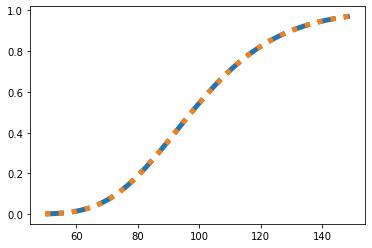

In [26]:
plt.plot(range(50,150),delta_curve,linestyle="dashed",linewidth=5)
plt.plot(range(50,150),delta_curve_dual_numbers,linestyle="dotted",linewidth=5)

The two resulting curves cannot be distinguished and the derivatives for all underlying values are equivalent. A problem may be that we want to evaluate not just the delta, but sizes like Theta (derivative w.r.t maturity) or Vega (derivative w.r.t. volatility). This would take linear time for both numerical differentiation and Forward Mode Automatic Differentiation. Latter would set the initial derivative value to 1 for each derivative case and repeat all calculations. A more efficient way to compute multiple derivatives for one output, while using synergies in the computation to avoid redundant computation, is Reverse Mode Automatic Differentiation.

## Reverse Mode Automatic Differentiation
### Definition of dual numbers with adjoint taping
For the Reverse Mode, a new number class is again introduced. Instead of carrying forward a derivative w.r.t to a single input, we save the previously discussed adjoint (intermediate or local) gradients for each elementary function or operation.
Remember following expression:
$${\bar{\nu}}_j+=\ {\bar{\nu}}_i\frac{\partial f_{i\left(u_i\right)}}{\partial v_{nj}}$$

This expression tells us that intermediate derivatives need to be saved and carried on. At the end, all local gradients are accumulated by multiplication. Analogously to the Forward Mode rules for differentiation (product rule, chain rule), the intermediate values of interest $$\frac{\partial f_{i\left(u_i\right)}}{\partial v_{nj}}$$ are computed w.r.t. each input value.

Analogously to the Forward Mode, a fixed set of differentiation rules applies to the Reverse Mode. At its core, we ask the question about the derivative $\frac{\partial f_{i\left(u_i\right)}}{\partial v_{nj}}$ in ${\bar{\nu}}_j+=\ {\bar{\nu}}_i\frac{\partial f_{i\left(u_i\right)}}{\partial v_{nj}}$.

Lets examine again the exact meaning of $\frac{\partial f_{i\left(u_i\right)}}{\partial v_{nj}}$ and how we can apply a fixed set of differentiation rules to calculate this value. The underlying reasoning will always ask the following question:$$\textbf{If I have two arguments of an elementary operation, how much would the result of this elementary operation change if the value of an argument increases?}$$ This view is applied for each argument as well as for the simple case where a function, e.g. the square root, is evaluated. In the one-argument case, the question will simply be $\textbf{How much does the function output change when changing the input?}$ 

Several cases need to be distinguished:

-  Addition $c=a+b$: Since the two arguments do not affect the contribution of each other on outcome $c$, both arguments increase their contribution by 1 if their respective values increase to 1. Hence their local gradient, or adjoint, equals to 1 for both.

-  Subtraction $c=a-b$: Analogous to the addition with the exception that the contributions are not symmetric. We would expect that the local gradient of $a$ is 1 and the value for $b$ is -1, since increasing $b$ by 1 will change $c$ by -1.

-  Multiplication: $c=ab$: Now, the value of $a$ does indeed affect the marginal contribution of $b$. For every unit increase of $a$, the value of $c$ increases by $b$ amount, which is symmetric such that the same holds for b$.

-  Division $c=\frac{a}{b}$: Division is highly asymmetrical. The analysis for the local gradient of $a$ is simple, since increasing a by one unit increases $c$ by $\frac{1}{b}$, since $a$ is multiplied by the fraction, we same rules as for multiplication are applied. The marginal effect of $a$ unit change of $b$, however, is more complicated to obtain since it depends on both the level of $a$ as well as $b$. The result can be obtained by taking the derivative of $\frac{a}{b}$ with respect to $b$.

We will see that these considerations directly translate to the definition of dual numbers.

In [27]:
class dual_number_reverse:
    def __init__(self,value,adjoint=()):
        self.value = value
        self.adjoint = adjoint
    
    def __add__(self,other):
        if type(other) == type(self):
            c = dual_number_reverse(None,None)
            
            c.value = self.value + other.value
            
            c.adjoint = ((self, 1), (other, 1))
            
            return c
            
    def __sub__(self,other):
        if type(other) == type(self):
            c = dual_number_reverse(None,None)
            
            c.value = self.value - other.value
            
            c.adjoint = ((self, 1),(other, -1))    
            return c  
            
    def __mul__ (self,other):
        if type(other) == type(self):
            c = dual_number_reverse(None,None)
            
            c.value = self.value * other.value
            
            c.adjoint = ((self, other.value),(other, self.value))
            
            return c
            
    def __truediv__ (self,other):
        if type(other) == type(self):
            c = dual_number_reverse(None,None)
            
            c.value = self.value / other.value
            
            c.adjoint = ((self, 1/ other.value),(other, - self.value/other.value**2) )
            
            return c
        else:
            c = dual_number_reverse(None,None)
            
            c.value = self.value / other
            
            c.adjoint = ((self, 1/ other),)
            
            return c

See that every elementary operation is simply redefined by **Operator Overloading**. The rules for each step are intuitive results from differentiation rules.

### Equipping elementary functions with adjoint taping

Note that we again do **do not have to change Black76**. We overload the same operations used before (square root, log) for the new dual number type for the Reverse Mode.

Note that the same question is asked every time: $\textbf{How much does the output of an elementary operation change when changing the argument?}$. It happens to be the case that this just corresponds to the derivatives of the defined functions.

In [28]:
def sqrt(x):
    if type(x)==dual_number_reverse:
        temp = dual_number_reverse(None,None)
        
        temp.value = np.sqrt(x.value)
        
        temp.adjoint = ( (x,0.5*(1 / x.value ** 0.5)),)
        
        return temp
    
    
    if type(x)==dual_number:
        temp = dual_number(None,None)
        
        temp.value = np.sqrt(x.value)
        
        temp.derivative = 0.5*(x.value**(0.5-1))*x.derivative
        
        return temp
    else:
        return np.sqrt(x)
    
def cdf(x):
    if type(x)==dual_number_reverse:
        
        temp = dual_number_reverse(None,None)
        
        temp.value =  norm.cdf(x.value)
        
        temp.adjoint = ((x, norm.pdf(x.value)),)
        
        return temp
    
    if type(x)==dual_number:
        temp = dual_number(None,None)
        
        temp.value =  norm.cdf(x.value)
        
        temp.derivative = norm.pdf(x.value)*x.derivative
        
        return temp
     
    else: 
        return norm.cdf(x)    

def log(x):
    if type(x)==dual_number_reverse:
        temp = dual_number_reverse(None,None)
        
        temp.value =  np.log(x.value)
        
        temp.adjoint = ((x, 1.0/x.value),)
        
        return temp
    
    if type(x)==dual_number:
        
        temp = dual_number(None,None)
        
        temp.value =  np.log(x.value)
        
        temp.derivative = (1/x.value)*x.derivative
        
        return temp
    else: 
        return np.log(x)    

**Note:** At this point, the similarity of the Forward Mode and the Reverse Mode become apparent.

We have not redefined the elementary functions like sqrt, log and cdf completely, but added case distinctions. For each number type, a separate operation is performed. The operations however are very similar. 

For the square root function, compare $$\text{ temp.derivative = 0.5*(x.value**(0.5-1))*x.derivative}$$ with $$\text{temp.adjoint = ( (x,0.5*(1/x.value**(0.5))),)}$$

The Forward Mode expression consists of one more multiplication, but performs equivalent remaining operations. The derivative values for the Forward Mode are carried from start to end of the evaluation trace.
The Reverse Mode can as a result collect all the valuable derivative information gathered by the Forward Mode. However, the intermediate steps are saved, and not overwritten such that intermediate derivatives are available for later evaluation. This means that most required calculations of the Reverse Mode are performed anyway for the Forward Mode, but former computes arbitrary number of sensitivities in constant time while latter requires linearly more time for each further sensitivity.

This exemplifies the **trade-off** between speed and memory of the Reverse Mode, since those performance gains are realized by taping intermediate results. How this taping looks in practice is shown in the next code example.

### Implementation of tape interpreter
Since all local adjoints are saved by each dual number itself, we need some way to keep track of them.

In Python, all outputs/variables/parameters are references to some objects that hold the value. By the virtue of this logic, every single intermediate step is also a reference to a value without any need to declare each intermediate step separately with a variable.

NOTE: This is part of Pythons powerful abstractions, behind the hood a lot of memory management and assignments are happening. As a consequence, the resulting Reverse Mode code is not optimal in terms of memory management and computational efficiency.


To sweep through all computational steps, we have logged the references of each computational step within each dual number. This means each dual numbers knows its child variables. We can recursively run though a variable to create a dictionary that can be seen as a Python version of the interpreted tape.

In [29]:
def get_gradients(variable):

    gradients = defaultdict(lambda: 0)
    
    def compute_gradients(variable, path_value):
        for child_variable, local_gradient in variable.adjoint:
          
            value_of_path_to_child = path_value * local_gradient
          
            gradients[child_variable] += value_of_path_to_child
           
            compute_gradients(child_variable, value_of_path_to_child)
    
    compute_gradients(variable, path_value=1)

    return gradients

The function recursively runs through all nodes. We **did not have to keep track** of the computational graph nor the tape. Introducing a tape explicitly may improve the numerical performance, while the following exposition should demonstrate the basics of the Reverse Mode. For basic functions, the Reverse Mode works as followed:

In [30]:
a = dual_number_reverse(3)
b = dual_number_reverse(3)
d=  b*(a*a)+a
print(d)
gradients = get_gradients(d)
print(gradients[a])

19


We can see that the resulting value is not an ordinary number, but a dual number. We can get the interpreted tape by calling the recursion of *get_gradient*. From there, we call the resulting tape/dictionary by **name**. This is possible because every variable (e.g. a,b,x) are references that are saved by name. Note that we did not specify at the beginning which derivative to compute. All sensitivities w.r.t. all inputs are computed as a result for the Reverse Mode.

### Evaluating Black76 with Reverse Mode
For the Reverse Mode, we again **do not need to change** the Black76-Formula. We define the new type of dual numbers and assign them to variables. This is in contrast to the Forward Mode, where we directly passed the values. We do this to make sure that references are passed in a way that we can call the variables by using readable variable names like "volatility" instead of some machine id. However, one could pass the values directly without any issue, only the retrieval of the derivatives from the dictionary by key would be more difficult.

In [31]:
forward_price = dual_number_reverse(50)
strike=dual_number_reverse(100)
volatility=dual_number_reverse(1)
maturity=dual_number_reverse(1)
option_type=dual_number_reverse(1)

In [32]:
Black76_dual_number_reverse = Black76(forward_price=forward_price,
        strike=strike,
        volatility=volatility,
        maturity=maturity,
        option_type=option_type)

print(Black76_dual_number_reverse.value)

9.530505761837919


We see that the function evaluation is equivalent to all previous methods.

In [33]:
Black76_dual_number_reverse.adjoint

((<__main__.dual_number_reverse at 0x160cf2e78d0>, 9.530505761837919),
 (<__main__.dual_number_reverse at 0x160cf30f5f8>, 1))

Calling the adjoint value of the result, we see the logged intermediate derivatives of the child nodes.

In [34]:
gradients = get_gradients(Black76_dual_number_reverse)

The gradients can be retrieved separately. 

### Illustration of resulting tape

The resulting tape can be visually inspected. First, remember how the tape was formally introduced:

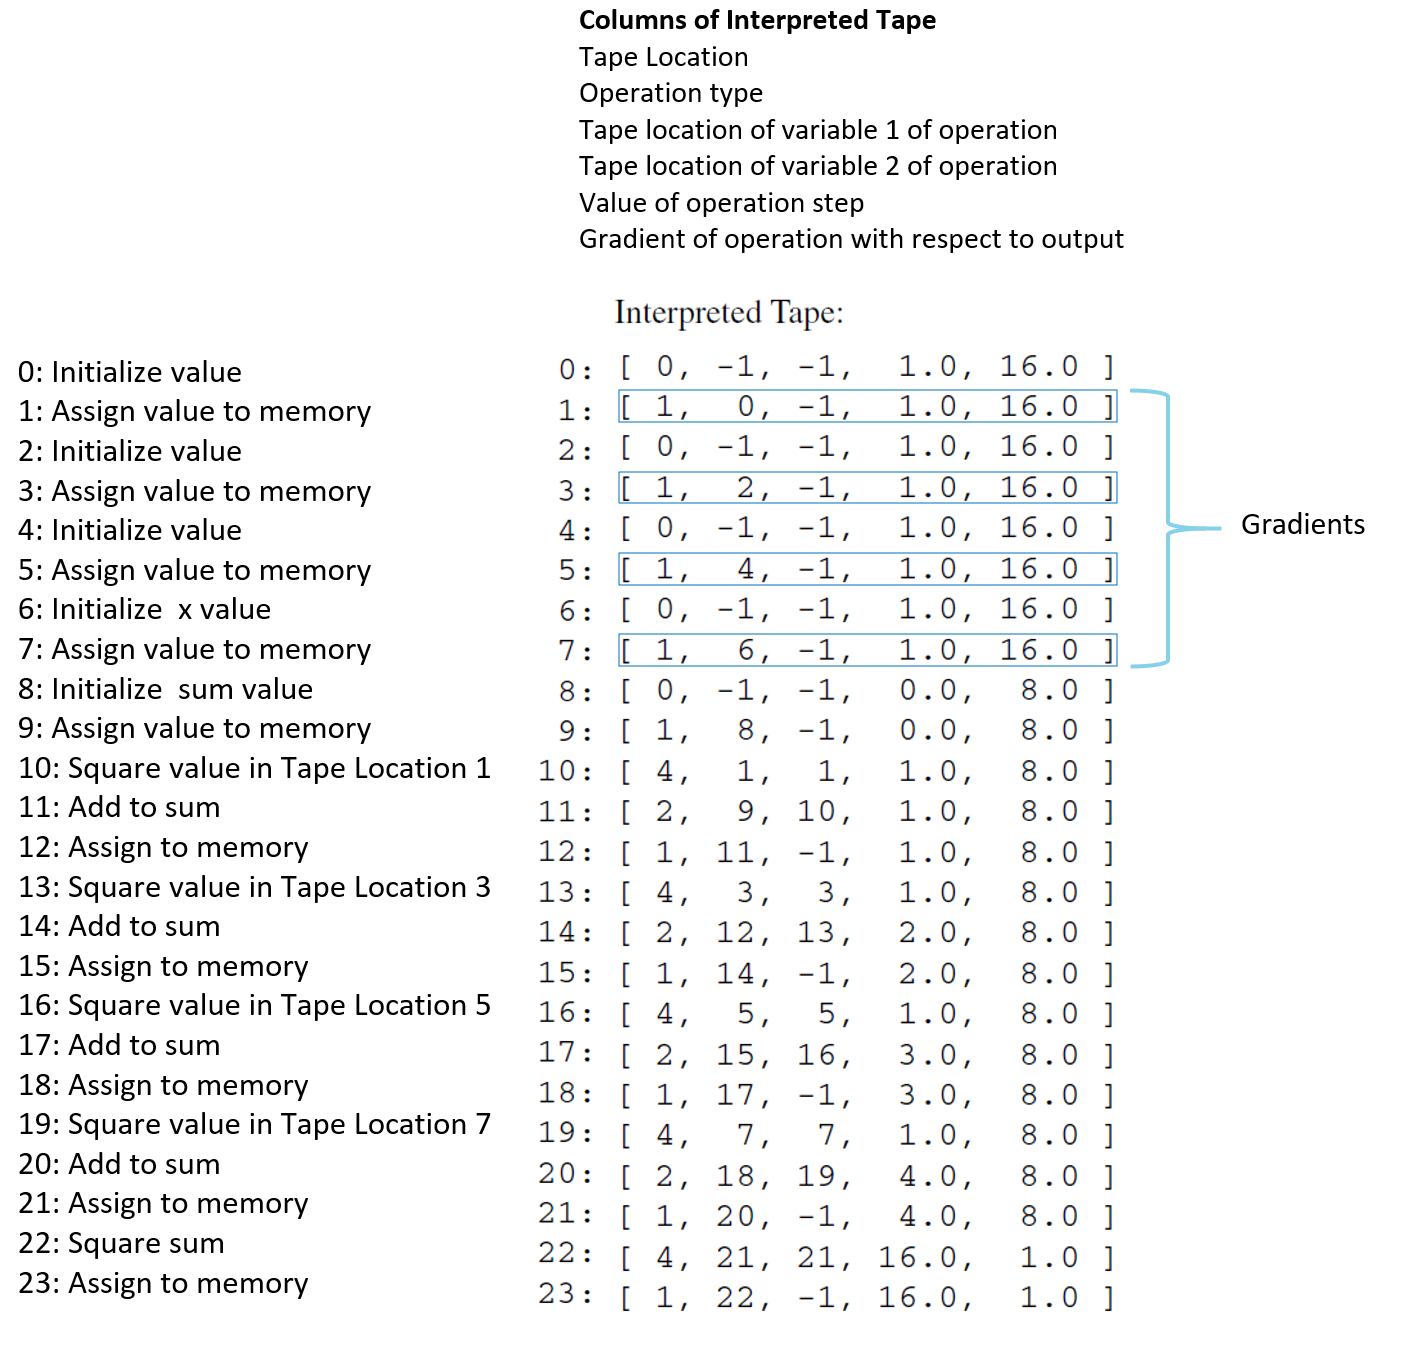

In [35]:
gradients

defaultdict(<function __main__.get_gradients.<locals>.<lambda>()>,
            {<__main__.dual_number_reverse at 0x160cf2e78d0>: 29.108996563098348,
             <__main__.dual_number_reverse at 0x160cf30f5f8>: 1,
             <__main__.dual_number_reverse at 0x160cf30f358>: 1,
             <__main__.dual_number_reverse at 0x160cf2e7908>: 0.4234218517607553,
             <__main__.dual_number_reverse at 0x160cf30f1d0>: 50,
             <__main__.dual_number_reverse at 0x160cf30f080>: 19.578490801260433,
             <__main__.dual_number_reverse at 0x160cf30f6a0>: 19.578490801260433,
             <__main__.dual_number_reverse at 0x160cf30fa90>: 19.578490801260433,
             <__main__.dual_number_reverse at 0x160cf2e7828>: 19.578490801260433,
             <__main__.dual_number_reverse at 0x160cf2e7940>: 39.156981602520865,
             <__main__.dual_number_reverse at 0x160cf2e77b8>: -0.11640586826199845,
             <__main__.dual_number_reverse at 0x160cf30f860>: 13.57077569851249

This tape corresponds to the presented tape in the presentation. The value is logged together with each computational step. The argument values are saved in each dual number reference and not shown separately, similar holds for the function value of each step. The tape location is a result of the recursion used to create the dictionary, i.e. the sweep through the computational graph. 

In [36]:
print("The partial derivative of the option price with respect to the forward price =", gradients[forward_price])
print("The partial derivative of the option price with respect to volatility =", gradients[volatility])
print("The partial derivative of the option price with respect to maturity =", gradients[maturity])

The partial derivative of the option price with respect to the forward price = 0.4234218517607553
The partial derivative of the option price with respect to volatility = 19.578490801260436
The partial derivative of the option price with respect to maturity = 9.789245400630218


We see that **all** derivatives can be called **by name**. In addition, the delta (derivative w.r.t. the forward price) is equivalent to the previous variants of differentiation.

### Properties of Reverse Mode
The runtime can now be measured. 

NOTE: For an accurate and reliable measurement, a controlled environment with repeated function executions is required. For exposition purposes, the following shows the performance of the Reverse Mode:

In [37]:
start = time.time()
Black76_dual_number_reverse = Black76(forward_price=forward_price,
        strike=strike,
        volatility=volatility,
        maturity=maturity,
        option_type=option_type)
gradients = get_gradients(Black76_dual_number_reverse)
end = time.time()

print("The partial derivative of the option price with respect to the underlying =", gradients[forward_price])
print("The partial derivative of the option price with respect to volatility =", gradients[volatility])
print("The partial derivative of the option price with respect to maturity =", gradients[maturity])
print(f"Runtime of the Reverse Mode is {round(1000*(end - start),3)}ms")

The partial derivative of the option price with respect to the underlying = 0.4234218517607553
The partial derivative of the option price with respect to volatility = 19.578490801260436
The partial derivative of the option price with respect to maturity = 9.789245400630218
Runtime of the Reverse Mode is 1.024ms


In [38]:
start = time.time()
forward_mode_delta=Black76(forward_price=dual_number(50,1),
        strike=dual_number(100,0),
        volatility=dual_number(1,0),
        maturity=dual_number(1,0),
        option_type=dual_number(1,0)).derivative
forward_mode_vega=Black76(forward_price=dual_number(50,0),
        strike=dual_number(100,0),
        volatility=dual_number(1,1),
        maturity=dual_number(1,0),
        option_type=dual_number(1,0)).derivative
forward_mode_theta=Black76(forward_price=dual_number(50,0),
        strike=dual_number(100,0),
        volatility=dual_number(1,0),
        maturity=dual_number(1,1),
        option_type=dual_number(1,0)).derivative
end = time.time()

print("The partial derivative of the option price with respect to the underlying =", forward_mode_delta)
print("The partial derivative of the option price with respect to volatility =", forward_mode_vega)
print("The partial derivative of the option price with respect to maturity =", forward_mode_theta)
print(f"Runtime of the Forward Mode is {1000*(end - start)}ms")

The partial derivative of the option price with respect to the underlying = 0.4234218517607553
The partial derivative of the option price with respect to volatility = 19.578490801260433
The partial derivative of the option price with respect to maturity = 9.789245400630216
Runtime of the Forward Mode is 3.9827823638916016ms


To compare a last time the values with the analytical derivatives, lets check the previous results:

In [39]:
print(f"The analytical delta is {delta_analytical}")
print(f"The analytical vega is {vega_analytical}")
print(f"The analytical theta is {theta_analytical}")

The analytical delta is 0.4234218517607552
The analytical vega is 19.578490801260433
The analytical theta is 9.789245400630216


We see that the obtained derivatives for the Forward Mode require multiple calls of the function and are equal in value when compared to the Reverse Mode (plus or minus rounding errors that were introduced by defining all operations for illustration purposes).

To relate the runtime of the differentiation modes to the runtime of the base function, we measure the time it takes to evaluate Black76:

As a more formal benchmark of the methods, we can perform many iterations and average the runtime:


In [40]:
def timereps(reps, func):
    start = time.time()
    for i in range(0, reps):
        func()
    end = time.time()
    return np.round(1000*(end - start) / reps,3)

def reverse_runtime():
    forward_price = dual_number_reverse(50)
    strike=dual_number_reverse(100)
    volatility=dual_number_reverse(1)
    maturity=dual_number_reverse(1)
    option_type=dual_number_reverse(1)
    Black76_dual_number_reverse = Black76(forward_price=forward_price,
            strike=strike,
            volatility=volatility,
            maturity=maturity,
            option_type=option_type)
    gradients = get_gradients(Black76_dual_number_reverse)
    reverse_mode_delta = gradients[forward_price]
    reverse_mode_vega = gradients[volatility]
    reverse_mode_theta = gradients[maturity]
    
def forward_runtime():
    forward_mode_delta=Black76(forward_price=dual_number(50,1),
        strike=dual_number(100,0),
        volatility=dual_number(1,0),
        maturity=dual_number(1,0),
        option_type=dual_number(1,0)).derivative
    forward_mode_vega=Black76(forward_price=dual_number(50,0),
        strike=dual_number(100,0),
        volatility=dual_number(1,1),
        maturity=dual_number(1,0),
        option_type=dual_number(1,0)).derivative
    forward_mode_theta=Black76(forward_price=dual_number(50,0),
        strike=dual_number(100,0),
        volatility=dual_number(1,0),
        maturity=dual_number(1,1),
        option_type=dual_number(1,0)).derivative

def base_runtime():
    base_evaluation = Black76(forward_price=50,strike=100,volatility=1,maturity=1,option_type=1)

To allow for a comparable evaluation, all functions will perform their calculations and then assign the results (function evaluations and derivatives) to variables. By doing this, memory overhead will be considered during performance evaluation (e.g. reading the results from the tape). 

In [41]:
reps = 10000
reverse_runtime_avg = timereps(reps, reverse_runtime)
forward_runtime_avg = timereps(reps, forward_runtime)
base_runtime_avg = timereps(reps, base_runtime)
print(r"The Reverse Mode runtime averaged over {} repetitions is {}ms".format(reps,reverse_runtime_avg))
print(r"The Forward Mode runtime averaged over {} repetitions is {}ms".format(reps,forward_runtime_avg))
print(r"The base function runtime averaged over {} repetitions is {}ms".format(reps,base_runtime_avg))

The Reverse Mode runtime averaged over 10000 repetitions is 0.423ms
The Forward Mode runtime averaged over 10000 repetitions is 1.151ms
The base function runtime averaged over 10000 repetitions is 0.193ms


Remember that the theoretical bounds for the Forward Model indicate a runtime of 2 up to 2.5 times the original function evaluation, for the Reverse Mode the bounds are between 3 and 4 respectively.
Since the Forward Mode needs to be executed 3 times for all three sensitivities, we expect 6 to 7.5 times the evaluation time of the original function.

In [42]:
print(r"The Reverse Mode runtime is around {} times of one base function evaluation".format(round(reverse_runtime_avg/base_runtime_avg,2)))
print(r"The Forward Mode runtime is around {} times of one base function evaluation".format(round(forward_runtime_avg/base_runtime_avg,2)))


The Reverse Mode runtime is around 2.19 times of one base function evaluation
The Forward Mode runtime is around 5.96 times of one base function evaluation


This demonstrates that even a minimal example can realize the theoretical performance gains. 